# Model for Top Lane players prediction

## Import MatPlotLib & Setup

In [45]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import Keras, Pandas & other used libraries

In [46]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

## Imports Data

In [47]:
df_game_events = pd.read_csv("../data/game_events.csv")
df_game_events.head()

game_events_features = ['timestamp', 'event_type', 'killer_id', 'killer_name', 'killer_team_id',]

#df_game_events.event_type.value_counts()
#df_game_events.drake_type.value_counts()
#df_game_events.killer_id.value_counts()

df_game_events.head()

,id,game_id,timestamp,event_type,killer_id,killed_id,assisting_player_ids,drake_type
0,0,0,229,player_kill,21.0,29.0,[23],NaN
1,1,0,289,player_kill,21.0,29.0,[23],NaN
2,2,0,499,player_kill,25.0,21.0,"[29, 22]",NaN
3,3,0,504,player_kill,22.0,23.0,"[29, 25]",NaN
4,4,0,535,player_kill,28.0,24.0,[27],NaN


In [48]:
df_game_metadata = pd.read_csv("../data/game_metadata.csv")
df_game_metadata.head()

game_metadata_features = ['game_id']

In [49]:
df_game_players_stats = pd.read_csv("../data/game_players_stats.csv")
df_game_players_stats.head()

game_players_stats_features_num = ['game_length', 'champion_name', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']

game_players_stats_features_by_user_num = ['team_id', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']
game_players_stats_features_by_user_cat = ['champion_name']


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
match_players = df_game_players_stats[df_game_players_stats['game_id'] == 0]
match_players.head(10)

,game_id,player_id,player_name,team_id,team_name,team_acronym,role,win,game_length,champion_name,team_kills,tower_kills,inhibitor_kills,dragon_kills,herald_kills,baron_kills,player_kills,player_deaths,player_assists,total_minions_killed,gold_earned,level,total_damage_dealt,total_damage_dealt_to_champions,total_damage_taken,wards_placed,largest_killing_spree,largest_multi_kill
30,0,21,Stark,4,Team Flash,TF,Top,True,2010,Renekton,22,10,1,2,1,2,4,4,9,275,14760,17,187887,12604,31066,18,2,1
31,0,22,Venus,5,Lowkey Esport Vietnam,LK,Support,False,2010,Nautilus,18,2,0,0,0,0,2,5,10,61,8188,13,23397,5298,12630,47,2,1
32,0,23,YiJin,4,Team Flash,TF,Jungle,True,2010,Sejuani,22,10,1,2,1,2,4,2,13,157,12963,16,165390,9776,38185,11,3,2
33,0,24,Celebrity,5,Lowkey Esport Vietnam,LK,Bot,False,2010,Ezreal,18,2,0,0,0,0,2,4,10,285,13108,16,197852,24770,13523,12,2,1
34,0,25,DNK,5,Lowkey Esport Vietnam,LK,Jungle,False,2010,Sylas,18,2,0,0,0,0,8,3,8,186,13850,16,169050,17982,27204,13,5,1
35,0,26,Artifact,5,Lowkey Esport Vietnam,LK,Mid,False,2010,Jayce,18,2,0,0,0,0,5,5,6,280,12926,17,171573,19579,15644,18,3,2
36,0,27,Hinn,4,Team Flash,TF,Support,True,2010,Morgana,22,10,1,2,1,2,1,4,16,15,8960,13,13032,4666,11567,59,0,1
37,0,28,Artemis,4,Team Flash,TF,Bot,True,2010,Lucian,22,10,1,2,1,2,9,6,7,289,15487,16,223488,20707,23348,11,4,2
38,0,29,Hani,5,Lowkey Esport Vietnam,LK,Top,False,2010,Kennen,18,2,0,0,0,0,1,5,5,229,11160,16,136281,10920,16643,13,0,1
39,0,30,C7N,4,Team Flash,TF,Mid,True,2010,Karma,22,10,1,2,1,2,4,2,11,303,15143,18,196700,14106,12036,15,2,2


## Preprocessing data for win determination with one player's data

In [50]:
player_roles = ['Top', 'Jungle', 'Mid', 'Support', 'Bot']

def get_solo_player_data(player_id : int, game_id : int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    df_player = df_game_players_stats[df_game_players_stats['game_id'] == game_id]
    
    # Filter by player_id
    df_player = df_player[df_player['player_id'] == player_id]
    
    # Create a new DataFrame with only the selected columns
    df_player_selected = df_player[game_players_stats_features_by_user_num + game_players_stats_features_by_user_cat]
    
    return df_player_selected


win_loose_preprocessor = make_column_transformer(
    (StandardScaler(), game_players_stats_features_by_user_num)
)

X = df_game_players_stats.loc[df_game_players_stats['role'] == player_roles[0]].copy()
y = X['win'].copy()
group = X['game_id'].copy()

X = X[game_players_stats_features_by_user_num]

def group_split(X: pd.DataFrame, y: pd.Series, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, group, train_size=0.75)

X_train = win_loose_preprocessor.fit_transform(X_train)
X_valid = win_loose_preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


## Model Training Win / Loose 

c:\Private\Folders\Ecam\4MIN\AI_Lab\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: >

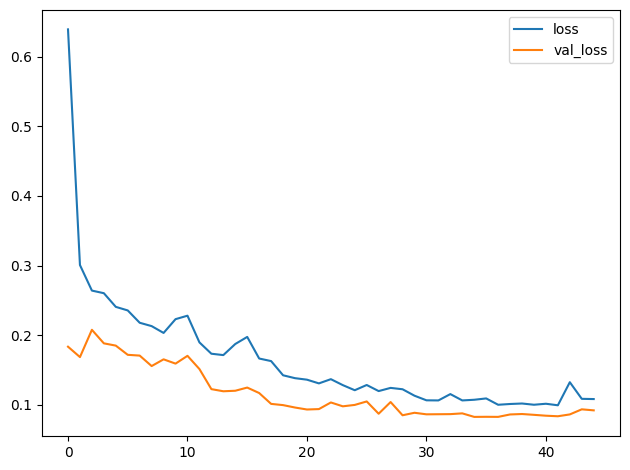

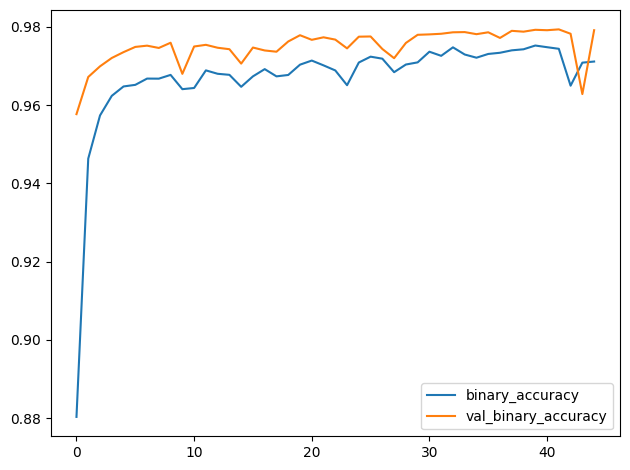

In [53]:
win_loose_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(1)
])

win_loose_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

win_loose_early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

win_loose_history = win_loose_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100,
    callbacks=[win_loose_early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(win_loose_history.history)
# Start the plot at epoch 5
history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()



## Preprocessing for performance model

In [52]:
def get_player_data(player_id: int, game_id: int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    game_data = df_game_players_stats[df_game_players_stats['game_id'] == game_id]
        
    # Filter by player_id
    player_data = game_data[game_data['player_id'] == player_id]
    
    # Calculate total kills in the match (across both teams)
    total_kills = game_data['player_kills'].sum()
    
    # Create a new DataFrame with only the selected columns
    player_selected = player_data[game_players_stats_features_num].copy()
    
    # Add the total kills column
    player_selected['total_match_kills'] = total_kills
    
    return player_selected

print(get_player_data(21, 0))

# Possibly add worthless death ratio & free kill ration, objective contest winrate & loserate
new_columns = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm', 
               'damage_dealt_tkr', 'damage_dealt_pgr', 'damage_taken_tkr', 'damage_taken_pgr',
               'largest_multikill', 'largest_killing_spree_tkr']

def get_final_input_features_performances(dataframe : pd.DataFrame) -> pd.DataFrame:
    
    new_df = pd.DataFrame()
    
    new_df['KLA'] = (dataframe['player_kills'] + dataframe['player_assists']) / (dataframe['player_deaths'] + 1)
    new_df['gold_pm'] = dataframe['gold_earned'] / dataframe['game_length']
    new_df['lvl_pm'] = dataframe['level'] / dataframe['game_length']
    new_df['creep_score_pm'] = dataframe['total_minions_killed'] / dataframe['game_length']
    new_df['wards_pm'] = dataframe['wards_placed'] / dataframe['game_length']
    new_df['damage_dealt_tkr'] = dataframe['total_damage_dealt'] / dataframe['total_match_kills']
    new_df['damage_dealt_pgr'] = new_df['damage_dealt_tkr'] / (dataframe['gold_earned'])
    new_df['damage_taken_tkr'] = dataframe['total_damage_taken'] / dataframe['total_match_kills']
    new_df['damage_taken_pgr'] = new_df['damage_taken_tkr'] / (dataframe['gold_earned'])
    new_df['largest_multikill'] = dataframe['largest_multi_kill']
    new_df['largest_killing_spree_tkr'] = dataframe['largest_killing_spree'] / dataframe['total_match_kills']
    
    return new_df

print(get_final_input_features_performances(get_player_data(21, 0)))
    




    game_length champion_name  tower_kills  inhibitor_kills  dragon_kills  \
30         2010      Renekton           10                1             2   

    herald_kills  baron_kills  player_kills  player_deaths  player_assists  \
30             1            2             4              4               9   

    total_minions_killed  gold_earned  level  total_damage_dealt  \
30                   275        14760     17              187887   

    total_damage_dealt_to_champions  total_damage_taken  wards_placed  \
30                            12604               31066            18   

    largest_killing_spree  largest_multi_kill  total_match_kills  
30                      2                   1                 40  
    KLA   gold_pm    lvl_pm  creep_score_pm  wards_pm  damage_dealt_tkr  \
30  2.6  7.343284  0.008458        0.136816  0.008955          4697.175   

    damage_dealt_pgr  damage_taken_tkr  damage_taken_pgr  largest_multikill  \
30          0.318237            776.65  